# Intro to Food Vision Mobile 🍔 👀📱

(This project was inspired by [@mrdbourke's](https://github.com/mrdbourke) excellent TF course, check it out: [Tensorflow Deep Learning](https://github.com/mrdbourke/tensorflow-deep-learning) )

![](demo.gif)

I was curious about how two well-known models, ResNet50 and ImageNet (trained on Food101 dataset), would perform runnining on a smartphone, in a browser using TensorFlow JS.

Using TFJS makes it very easy to test these models in the wild - would they perform OK?

My approach was to extract image features from ResNet50V2, ImageNetV2, fit them to Food101 dataset and finally convert them to Tensorflow JS.

#Load helper functions

In [1]:
# Get helper functions file (credit: @mrdbourke)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-01 08:07:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-01 08:07:04 (65.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
# View random images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_images(target_dir, target_class, how_many=9):
  # Set up target folder
  target_folder = target_dir + target_class

  how_many = 16 if (how_many > 16 or how_many < 1) else how_many
  
  # Get a random image path
  random_images = random.sample(os.listdir(target_folder), how_many)

  # Read in the image and plot it using matplotlib
  
  plt.figure(figsize=(12,16))
  for idx, random_image in enumerate(random_images):
    img = mpimg.imread(target_folder + "/" + random_image)
    plt.subplot(4, 4, idx + 1)
    plt.imshow(img)
    plt.title(f"{target_class} \n {random_image} \n {img.shape}")
    plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image





In [2]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-7c19e649-4bdb-33e0-f4b2-2c35bf33c89c)


In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import walk_through_dir, create_tensorboard_callback, plot_loss_curves, calculate_results, unzip_data

# Download data - 10% of Food101

In [4]:
# Download data
!wget https://mldatatwk.s3.us-east-2.amazonaws.com/101_food_classes_10_percent.zip

--2021-06-01 08:07:16--  https://mldatatwk.s3.us-east-2.amazonaws.com/101_food_classes_10_percent.zip
Resolving mldatatwk.s3.us-east-2.amazonaws.com (mldatatwk.s3.us-east-2.amazonaws.com)... 52.219.106.250
Connecting to mldatatwk.s3.us-east-2.amazonaws.com (mldatatwk.s3.us-east-2.amazonaws.com)|52.219.106.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  16.3MB/s    in 98s     

2021-06-01 08:08:54 (15.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# Unzip the downloaded file

unzip_data("101_food_classes_10_percent.zip")

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
walk_through_dir("101_food_classes_10_percent")


## Creating data loaders

In [7]:
# Setup data inputs
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)

# Gotcha - Keras' rescaling layers are to compatible with TF JS, this is an alternative
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

print("Training images: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=IMAGE_SHAPE, # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

print("Testing images:") 
test_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               seed=42)



Training images: 
Found 7575 images belonging to 101 classes.
Testing images:
Found 25250 images belonging to 101 classes.


In [ ]:
# Double-check we have correct food classes
len(train_data.classes)
food_classes = [food_class for food_class in train_data.class_indices]
food_classes

## Explore data

Image shape: (512, 512, 3)


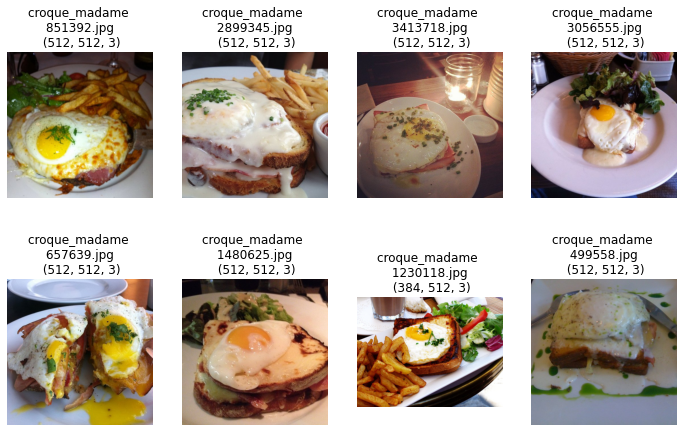

In [28]:
view_random_images('101_food_classes_10_percent/test/', random.choice(food_classes), how_many=8)

In [ ]:
## Double-check if pixel values are being rescaled
for elem in train_data:
  print(elem[0][0])
  break

# Build and train a ResNet50V2 feature extract model on 10% Food101 data (baseline)

In [29]:
js_model_path = "resnet_js_model"
saved_model_path = "resnet_model"

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"



In [12]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

resnet_feature_extractor_layer = hub.KerasLayer(resnet_url,
                                         trainable=False,
                                         name="feature_extraction_layer")


x = resnet_feature_extractor_layer(inputs)

x = tf.keras.layers.Dropout(0.3)(x)


outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

resnet_model = tf.keras.Model(inputs, outputs)

resnet_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [13]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)
resnet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               206949    
Total params: 23,771,749
Trainable params: 206,949
Non-trainable params: 23,564,800
_________________________________________________________________


Saving TensorBoard log files to: tensorflow_hub/simple_feature_extract_resnet50V2_dropout_03_resnet_5/20210527-152813
Epoch 1/5
237/237 [==============================] - 64s 195ms/step - loss: 3.5910 - accuracy: 0.2088 - val_loss: 2.3357 - val_accuracy: 0.4213
Epoch 2/5
237/237 [==============================] - 54s 228ms/step - loss: 2.0822 - accuracy: 0.4681 - val_loss: 2.1828 - val_accuracy: 0.4438
Epoch 3/5
237/237 [==============================] - 44s 185ms/step - loss: 1.6262 - accuracy: 0.5714 - val_loss: 2.0872 - val_accuracy: 0.4624
Epoch 4/5
237/237 [==============================] - 54s 226ms/step - loss: 1.3079 - accuracy: 0.6475 - val_loss: 2.0844 - val_accuracy: 0.4771
Epoch 5/5
237/237 [==============================] - 53s 226ms/step - loss: 1.0857 - accuracy: 0.7086 - val_loss: 2.1332 - val_accuracy: 0.4620


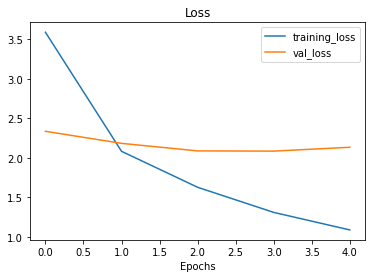

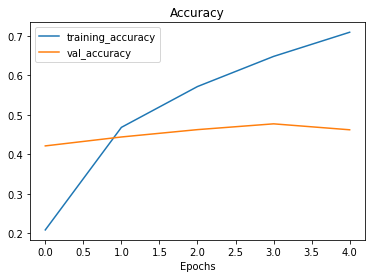

In [14]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=int(len(train_data)),
                                  validation_data=test_data,
                                  validation_steps=int(0.1*len(test_data)),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub", "simple_feature_extract_resnet50V2_dropout_03")]
                                 )
plot_loss_curves(resnet_history)

In [18]:
resnet_model.evaluate(test_data)

790/790 [==============================] - 112s 142ms/step - loss: 2.0871 - accuracy: 0.4780


[2.0870752334594727, 0.47798019647598267]

In [20]:
save_dir = "/content/drive/MyDrive/ML/food_vision/"+js_model_path+"/"

# Save model locally
resnet_model.save(saved_model_path)

# Save model backup to Google Drive 
resnet_model.save(save_dir+saved_model_path)


INFO:tensorflow:Assets written to: resnet_model/assets


INFO:tensorflow:Assets written to: resnet_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/simple_feature_extract_resnet50V2_successful_js/resnet_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/simple_feature_extract_resnet50V2_successful_js/resnet_model/assets


## Convert ResNet model to TFJS

In [ ]:
!pip install tensorflowjs 

!mkdir "{js_model_path}"

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model "{saved_model_path}/" "{js_model_path}/"

!zip -r "{js_model_path}.zip" "{js_model_path}" 

# Download the JS model
from google.colab import files
files.download(js_model_path+'.zip')

# Build and train a MobileNet V2 feature extraction model on 10% Food101 data

In [33]:
js_model_path = "mobilenet_v2_js_model"
saved_model_path = "mobilenet_v2_model"

mobile_net_v2_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [34]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers



In [35]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

feature_extract_layer = hub.KerasLayer(mobile_net_v2_url,
                                         trainable=False,
                                         name="feature_extract_layer")

x = feature_extract_layer(inputs)

x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
feature_extract_layer (Keras (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_________________________________________________________________


Saving TensorBoard log files to: tensorflow_hub/feature_extract_mobile_net_v2/20210601-091009
Epoch 1/5
237/237 [==============================] - 69s 215ms/step - loss: 3.4461 - accuracy: 0.2226 - val_loss: 2.3014 - val_accuracy: 0.4233
Epoch 2/5
237/237 [==============================] - 50s 209ms/step - loss: 2.0749 - accuracy: 0.4752 - val_loss: 1.9872 - val_accuracy: 0.4901
Epoch 3/5
237/237 [==============================] - 58s 244ms/step - loss: 1.6696 - accuracy: 0.5645 - val_loss: 1.9534 - val_accuracy: 0.4956
Epoch 4/5
237/237 [==============================] - 58s 244ms/step - loss: 1.4094 - accuracy: 0.6306 - val_loss: 1.8289 - val_accuracy: 0.5289
Epoch 5/5
237/237 [==============================] - 58s 243ms/step - loss: 1.2158 - accuracy: 0.6779 - val_loss: 1.8507 - val_accuracy: 0.5249


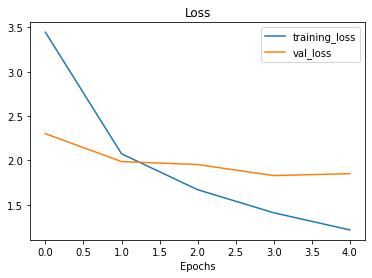

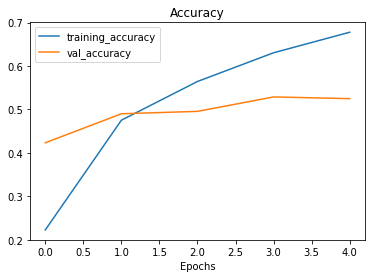

In [38]:
model_history = model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=int(len(train_data)),
                                  validation_data=test_data,
                                  validation_steps=int(0.1*len(test_data)),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub", "feature_extract_mobile_net_v2")]
                                 )
plot_loss_curves(model_history)

### MobileNetV2 on the same data performs better than ResNet50


In [39]:
# 52% vs 46% on ResNet, despite on 2.4M params (ResNet is 23.7M)
model.evaluate(test_data)

790/790 [==============================] - 123s 156ms/step - loss: 1.8354 - accuracy: 0.5244


[1.8354127407073975, 0.5243960618972778]

In [41]:
save_dir = "/content/drive/MyDrive/ML/food_vision/"+js_model_path+"/"

# Save model locally
model.save(saved_model_path)

# Save model backup to Google Drive 
model.save(save_dir+saved_model_path)

INFO:tensorflow:Assets written to: mobilenet_v2_model/assets


INFO:tensorflow:Assets written to: mobilenet_v2_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/mobilenet_v2_js_model/mobilenet_v2_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/mobilenet_v2_js_model/mobilenet_v2_model/assets


In [42]:
!pip install tensorflowjs 

!mkdir "{js_model_path}"

     |████████████████████████████████| 71kB 2.2MB/s 
     |████████████████████████████████| 112kB 3.9MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [43]:
!tensorflowjs_converter --input_format=tf_saved_model "{saved_model_path}/" "{js_model_path}/"

!zip -r "{js_model_path}.zip" "{js_model_path}" 

# Download the JS model
from google.colab import files
files.download(js_model_path+'.zip')

2021-06-01 09:29:28.250678: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-01 09:29:30.066055: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-01 09:29:30.071246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-01 09:29:30.072015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-06-01 09:29:30.072059: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-01 09:29:30.078846: I tensorflow/stream_executor/pl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>